In [4]:
import pandas as pd
import numpy as np
import ast
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Ellipse, Circle
from matplotlib.lines import Line2D
import seaborn as sns

from tqdm import tqdm

# pd.set_option('display.max_rows', 500)
# sns.set_theme(style="whitegrid", palette="viridis")

from IPython.display import HTML
mycols = sns.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)
mycols

[(0.86, np.float64(0.3712), 0.33999999999999997),
 (np.float64(0.8287999999999999), 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, np.float64(0.3712)),
 (0.33999999999999997, np.float64(0.8287999999999999), 0.86),
 (np.float64(0.3712), 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, np.float64(0.8287999999999999))]

In [12]:
# Predefined lookup and type dictionary
grid = (11,11)
reward_place_to_coord = {
    "u": ((grid[0] // 2, grid[1] - 1),),
    "r": ((grid[0] - 1, grid[1] // 2),),
    "d": ((grid[0] // 2, 0),),
    "l": ((0, grid[1] // 2),),
    "ur": ((grid[0] // 2, grid[1] - 1), (grid[0] - 1, grid[1] // 2)),
    "rd": ((grid[0] - 1, grid[1] // 2), (grid[0] // 2, 0)),
    "dl": ((grid[0] // 2, 0), (0, grid[1] // 2)),
    "ul": ((0, grid[1] // 2), (grid[0] // 2, grid[1] - 1)),
    "ud": ((grid[0] // 2, grid[1] - 1), (grid[0] // 2, 0)),
    "rl": ((grid[0] - 1, grid[1] // 2), (0, grid[1] // 2)),
    # Note: Replace this with the updated one
}        # Mapping from reward identifiers to board coordinates.


In [27]:
pairs = 51
# read csv with these columns and datatypes
store = f"../store_bk/{pairs}/logs/"
regime = 1
edf = pd.read_parquet(f'{store}testing_{regime}.parquet')

stats = f"../store_bk/{pairs}/trial_stats/"
sdf = pd.read_parquet(f'{stats}testing_{regime}.parquet')


In [28]:
print(sdf.keys())

Index(['trial_id', 'trial_length', 'activated', 'collected', 'wz_cancel',
       'collected_zone', 'reward_loc', 'activated_by', 'activated_frame',
       'first_close_to_zone', 'first_close_to_zone_frame', 'first_to_zone',
       'first_to_zone_frame', 'reward_counter'],
      dtype='object')


In [29]:
print(edf.keys())

Index(['regime_idx', 'frame_idx', 'reward_loc', 'activated', 'collected',
       'terminated', 'steps_without_reward', 'a1x', 'a1y', 'a2x', 'a2y', 'r1',
       'r2'],
      dtype='object')


In [30]:
sdf.collected.value_counts()

collected
True     85886
False      178
Name: count, dtype: int64

In [31]:
def get_reward_coord(zone):
    """Return the first coordinate tuple from the lookup, or (None, None) if not found."""
    if zone in reward_place_to_coord and reward_place_to_coord[zone]:
        return reward_place_to_coord[zone][0]
    else:
        return (None, None)

In [32]:
def get_lf(strat_coln, tdf):
    pad_size = 60
    g1x = tdf[strat_coln == "a1"].groupby("trial_id")["a1x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby("trial_id")["a1y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby("trial_id")["a2x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby("trial_id")["a2y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    leader_trace_x = np.concatenate((lax, lbx), axis=0)
    leader_trace_y = np.concatenate((lay, lby), axis=0)

    g1x = tdf[strat_coln == "a1"].groupby("trial_id")["a2x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby("trial_id")["a2y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby("trial_id")["a1x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby("trial_id")["a1y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    follower_trace_x = np.concatenate((lax, lbx), axis=0)
    follower_trace_y = np.concatenate((lay, lby), axis=0)
    
    return leader_trace_x, leader_trace_y, follower_trace_x, follower_trace_y

## Single training analysis

### basic

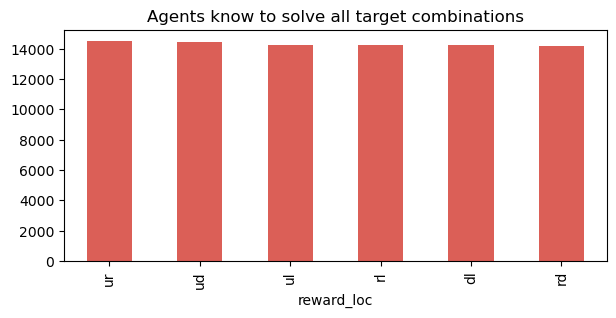

In [33]:
ax = sdf[sdf.collected].reward_loc.value_counts().plot(kind='bar', figsize=(7, 3), title='Agents know to solve all target combinations', color=mycols[0])

<Axes: title={'center': 'But they dont choose \nthe actual target spot equally'}, xlabel='collected_zone'>

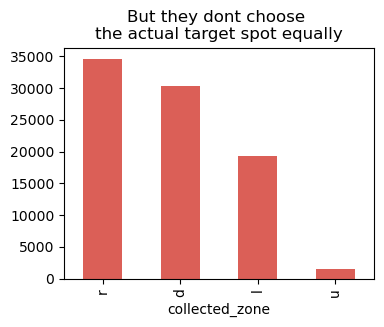

In [34]:
sdf[sdf.collected].collected_zone.value_counts().plot(kind='bar', figsize=(4, 3), title='But they dont choose \nthe actual target spot equally', color=mycols[0])

In [35]:
tdf = edf.copy()
tdf["trial_id"] = tdf.terminated.cumsum().shift(fill_value=0)

In [36]:
# Create new coordinate columns in the trial dataframe
sdf["rx"] = sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[0])
sdf["ry"] = sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[1])
# Merge the coordinate columns into the timestep dataframe based on trial_id
tdf = tdf.merge(sdf[['trial_id','trial_length', 'collected', 'collected_zone', "wz_cancel", 'activated_by', 'activated_frame', 'first_close_to_zone', 'first_close_to_zone_frame', 'first_to_zone', 'first_to_zone_frame', 'reward_counter', 'rx', 'ry']], on="trial_id", how="left")
# tdf.dropna(inplace=True)

In [68]:
tdf.keys()

Index(['regime_idx', 'frame_idx', 'reward_loc', 'activated', 'collected_x',
       'terminated', 'steps_without_reward', 'a1x', 'a1y', 'a2x', 'a2y', 'r1',
       'r2', 'trial_id', 'trial_length', 'collected_y', 'collected_zone',
       'wz_cancel', 'activated_by', 'activated_frame', 'first_close_to_zone',
       'first_close_to_zone_frame', 'first_to_zone', 'first_to_zone_frame',
       'reward_counter', 'rx', 'ry'],
      dtype='object')

### Distance to target

In [38]:
tdf["a1_dr"] = np.sqrt((tdf["rx"] - tdf["a1x"])**2 + (tdf["ry"] - tdf["a1y"])**2)
tdf["a2_dr"] = np.sqrt((tdf["rx"] - tdf["a2x"])**2 + (tdf["ry"] - tdf["a2y"])**2)

In [39]:
def get_lf_dr(strat_coln):
    g1 = tdf[strat_coln == "a1"].groupby("trial_id")["a1_dr"].apply(list)
    la = np.array([lst + [np.nan]*(11 - len(lst)) for lst in g1])
    g2 = tdf[strat_coln == "a2"].groupby("trial_id")["a2_dr"].apply(list)
    lb = np.array([lst + [np.nan]*(11 - len(lst)) for lst in g2])

    leader_trace = np.concatenate((la, lb), axis=0)

    g1 = tdf[strat_coln == "a1"].groupby("trial_id")["a2_dr"].apply(list)
    la = np.array([lst + [np.nan]*(11 - len(lst)) for lst in g1])
    g2 = tdf[strat_coln == "a2"].groupby("trial_id")["a1_dr"].apply(list)
    lb = np.array([lst + [np.nan]*(11 - len(lst)) for lst in g2])

    follower_trace = np.concatenate((la, lb), axis=0)
    
    return leader_trace, follower_trace

In [40]:
l1, f1 = get_lf_dr(tdf.activated_by)
l2, f2 = get_lf_dr(tdf.first_close_to_zone)
l3, f3 = get_lf_dr(tdf.first_to_zone)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (36690,) + inhomogeneous part.

In [ ]:
l1.shape, f1.shape, l2.shape, f2.shape, l3.shape, f3.shape

((80149, 11), (80149, 11), (68192, 11), (68192, 11), (40459, 11), (40459, 11))

In [ ]:
def subsample(ndarray, size=2000):
    indices = np.random.choice(ndarray.shape[0], size, replace=False)
    return indices

NameError: name 'subsample' is not defined

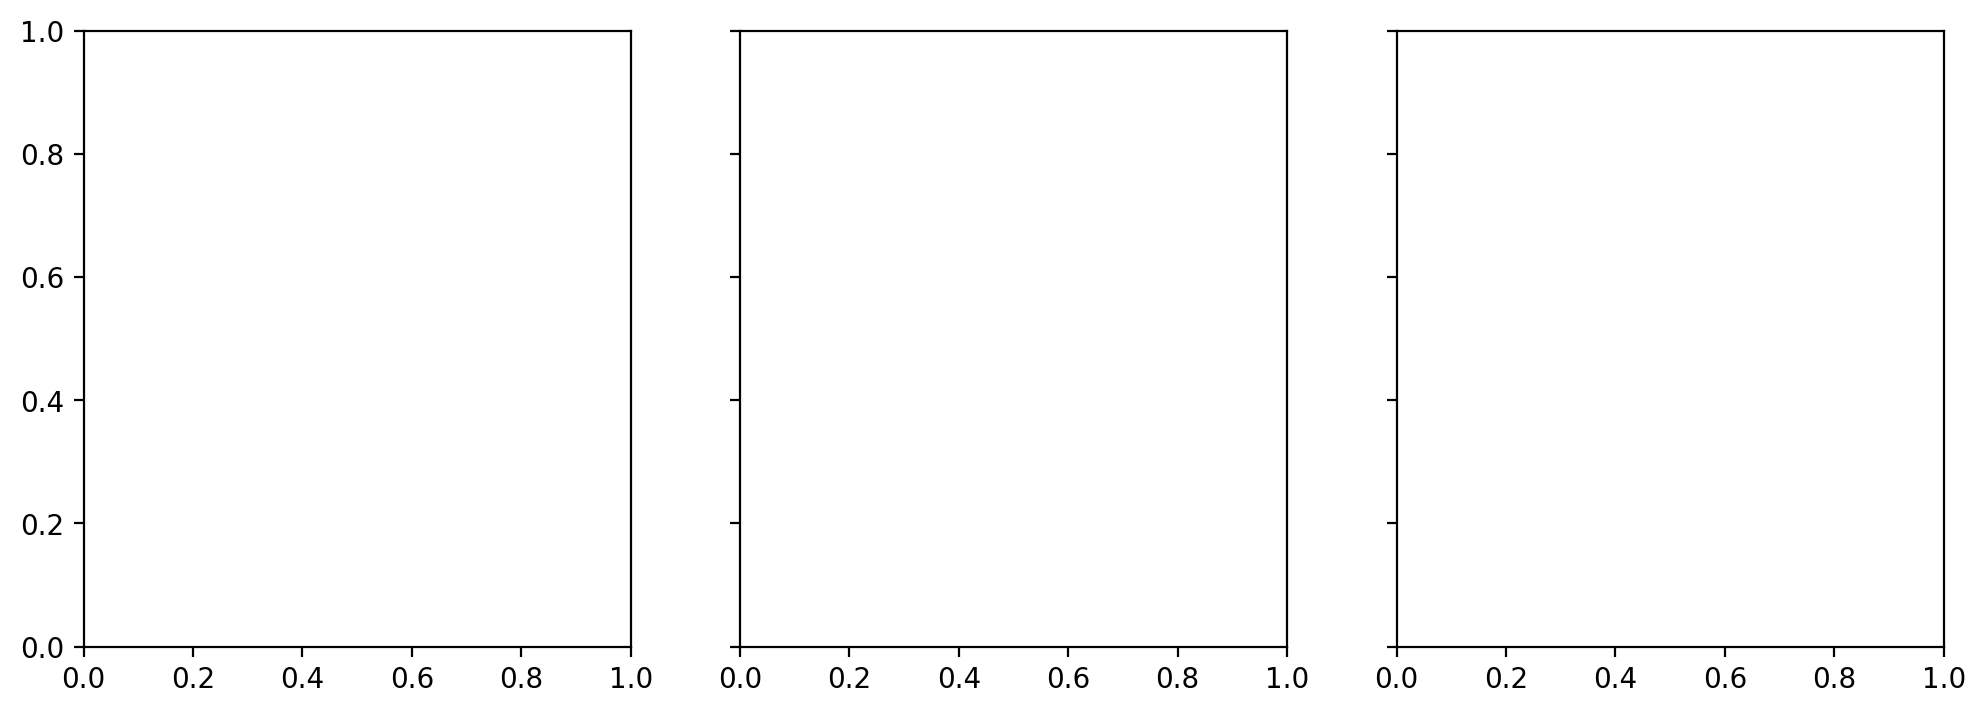

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=200)
# Plot the leader and follower traces for each strategy

for i in subsample(l1, 2000):
    ax[0].plot(l1[i], color='blue', alpha=0.01)
    ax[0].plot(f1[i], color='orange', alpha=0.01)
ax[0].set_ylabel('Dist. to reward spot', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[0].set_title('Leader is first to activate', fontsize=12, fontweight='bold')
ax[0].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 1', 'Follower 1'], loc='upper right', fontsize=10, frameon=False
)

for i in subsample(l2, 2000):
    ax[1].plot(l2[i], color='blue', alpha=0.01)
    ax[1].plot(f2[i], color='orange', alpha=0.01)
ax[1].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[1].set_title('Leader first in < 2 a.u. zone', fontsize=12, fontweight='bold')
ax[1].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 2', 'Follower 2'], loc='upper right', fontsize=10, frameon=False
)

for i in subsample(l3, 2000):
    ax[2].plot(l3[i], color='blue', alpha=0.01)
    ax[2].plot(f3[i], color='orange', alpha=0.01)
ax[2].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[2].set_title('Leader is first to rw spot', fontsize=12, fontweight='bold')
ax[2].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 3', 'Follower 3'], loc='upper right', fontsize=10, frameon=False
)

plt.suptitle('Evaluation - raw distance to reward spot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'l1' is not defined

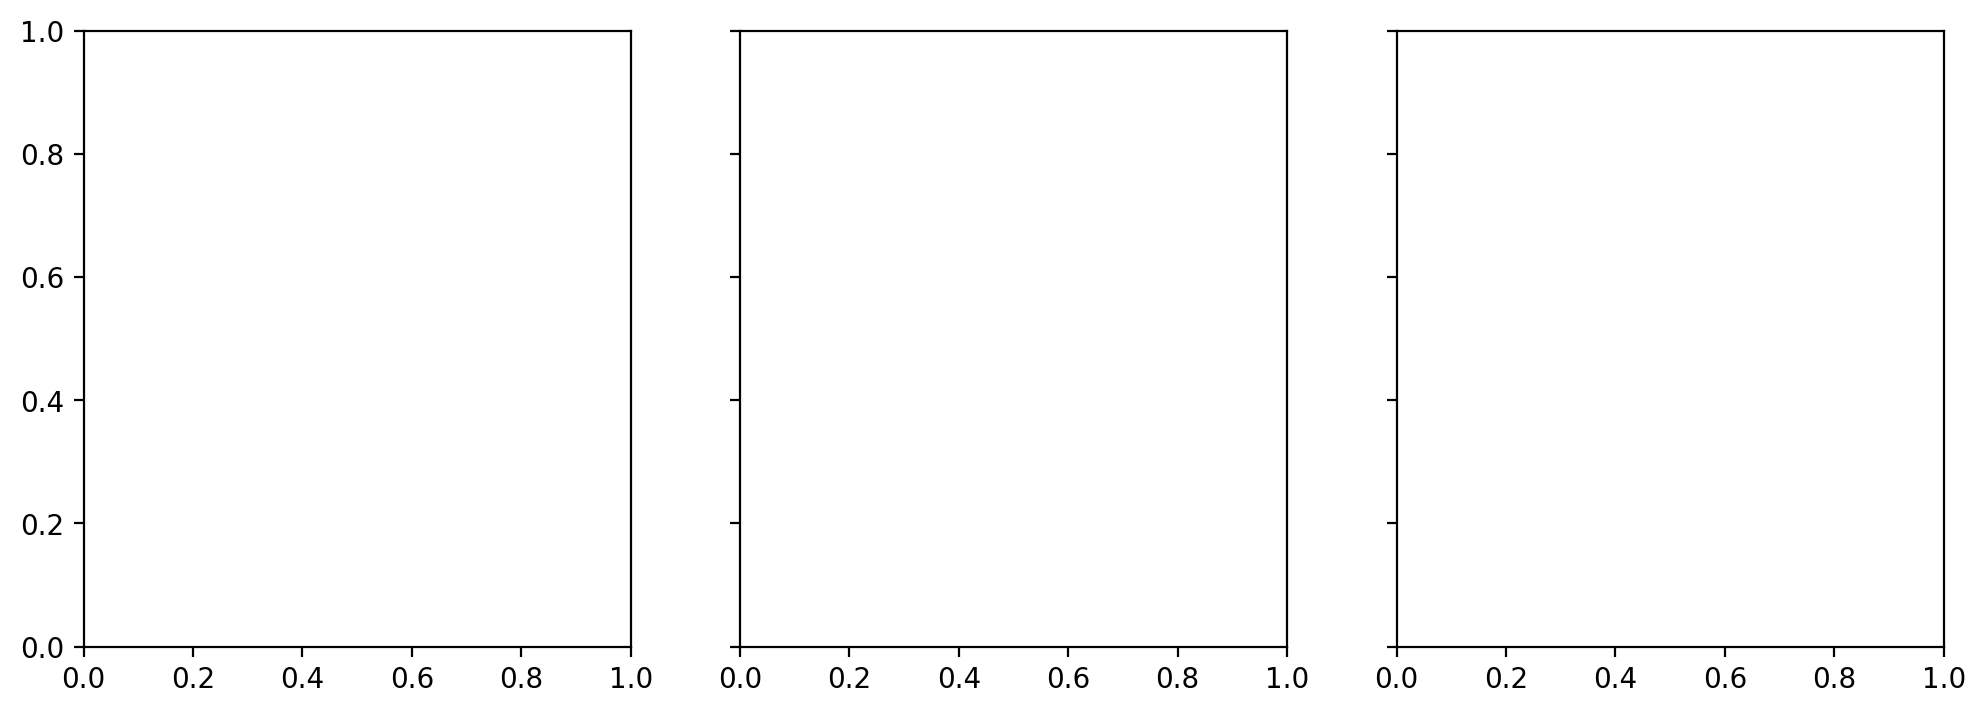

In [42]:
# now lets do the same thing but with mean and std
def get_mean_std(ndarray):
    """Calculate the mean and standard deviation for each timestep across trials."""
    mean = np.nanmean(ndarray, axis=0)
    std = np.nanstd(ndarray, axis=0)
    return mean, std
def plot_mean_std(ax, mean, std, color, label):
    """Plot the mean and standard deviation as a filled area."""
    ax.plot(mean, color=color, label=label)
    ax.fill_between(range(len(mean)), mean - std, mean + std, color=color, alpha=0.2)
# Create a new figure for mean and std plots
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=200)
# Plot the mean and std for leader and follower traces for each strategy
mean_l1, std_l1 = get_mean_std(l1)
mean_f1, std_f1 = get_mean_std(f1)
plot_mean_std(ax[0], mean_l1, std_l1, 'blue', 'Leader 1')
plot_mean_std(ax[0], mean_f1, std_f1, 'orange', 'Follower 1')
mean_l2, std_l2 = get_mean_std(l2)
mean_f2, std_f2 = get_mean_std(f2)
plot_mean_std(ax[1], mean_l2, std_l2, 'blue', 'Leader 2')
plot_mean_std(ax[1], mean_f2, std_f2, 'orange', 'Follower 2')
mean_l3, std_l3 = get_mean_std(l3)
mean_f3, std_f3 = get_mean_std(f3)
plot_mean_std(ax[2], mean_l3, std_l3, 'blue', 'Leader 3')
plot_mean_std(ax[2], mean_f3, std_f3, 'orange', 'Follower 3')
ax[0].set_ylabel('Dist. from reward spot', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[2].set_xlabel('Timesteps from activation', fontsize=12, fontweight='bold')
ax[0].set_title('Leader is first to activate', fontsize=12, fontweight='bold')
ax[1].set_title('Leader first in < 2 a.u. zone', fontsize=12, fontweight='bold')
ax[2].set_title('Leader is first to rw spot', fontsize=12, fontweight='bold')
ax[0].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 1', 'Follower 1'], loc='upper right', fontsize=10, frameon=False
)
ax[1].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 2', 'Follower 2'], loc='upper right', fontsize=10, frameon=False
)
ax[2].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 3', 'Follower 3'], loc='upper right', fontsize=10, frameon=False
)

plt.suptitle('Evaluation - Mean and Std Dist. to Reward Spot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Cumulative Distance

In [43]:
# lets now plot the cumulative distance of agents.

In [44]:
tdf = edf.copy()
tdf["trial_id"] = tdf.terminated.cumsum().shift(fill_value=0)
tdf = tdf.merge(sdf[['trial_id','trial_length', 'collected', 'collected_zone', "wz_cancel", 'activated_by', 'activated_frame', 'first_close_to_zone', 'first_close_to_zone_frame', 'first_to_zone', 'first_to_zone_frame', 'reward_counter', 'rx', 'ry']], on="trial_id", how="left")
# tdf.dropna(inplace=True)

In [45]:
tdf[tdf.activated_by == "a1"].groupby("trial_id")["a1x"].apply(list)

trial_id
0                         [3, 4, 5, 6, 7, 8, 9, 9, 10, 10]
1                [3, 4, 4, 4, 4, 5, 6, 7, 8, 9, 9, 10, 10]
2          [10, 10, 9, 8, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
5                              [6, 6, 5, 4, 3, 2, 1, 1, 0]
8                           [3, 4, 4, 4, 5, 4, 3, 2, 1, 0]
                               ...                        
86049    [1, 1, 2, 3, 4, 5, 4, 4, 5, 6, 7, 7, 8, 8, 9, ...
86051                            [4, 5, 5, 6, 7, 8, 9, 10]
86055    [6, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10]
86059                 [1, 1, 2, 3, 3, 4, 5, 4, 3, 2, 1, 0]
86060    [6, 6, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, ...
Name: a1x, Length: 36690, dtype: object

In [52]:
l1x, l1y, f1x, f1y = get_lf(tdf.activated_by, tdf)
l2x, l2y, f2x, f2y = get_lf(tdf.first_close_to_zone, tdf)
l3x, l3y, f3x, f3y = get_lf(tdf.first_to_zone, tdf)
l1x.shape, l1y.shape, f1x.shape, f1y.shape, l2x.shape, l2y.shape, f2x.shape, f2y.shape, l3x.shape, l3y.shape, f3x.shape, f3y.shape

((78758, 60),
 (78758, 60),
 (78758, 60),
 (78758, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60))

In [53]:
# now for each coordinate, we will do a cumulative sum of the distance moved over the timesteps
def get_cumulative_distance(x, y):
    """Calculate the cumulative distance moved for each coordinate."""
    # Retain wherever nans are present to keep in final output
    
    nx = np.where(np.isnan(x), np.nan, x)
    ny = np.where(np.isnan(y), np.nan, y)
    # Calculate the differences in x and y coordinates, then compute the distance
    # and cumulative distance  
    dx = np.diff(x, axis=1)
    dy = np.diff(y, axis=1)
    dist = np.sqrt(dx**2 + dy**2)
    cum_dist = np.nancumsum(dist, axis=1)
    
    # fill the first column with zeros to represent the starting point
    cum_dist = np.insert(cum_dist, 0, 0, axis=1)
    
    # Apply the nan mask to retain the original shape with nans
    cum_dist = np.where(np.isnan(nx), np.nan, cum_dist)
    cum_dist = np.where(np.isnan(ny), np.nan, cum_dist)
    return cum_dist

l1_cd = get_cumulative_distance(l1x, l1y)
f1_cd = get_cumulative_distance(f1x, f1y)
l2_cd = get_cumulative_distance(l2x, l2y)
f2_cd = get_cumulative_distance(f2x, f2y)
l3_cd = get_cumulative_distance(l3x, l3y)
f3_cd = get_cumulative_distance(f3x, f3y)

NameError: name 'subsample' is not defined

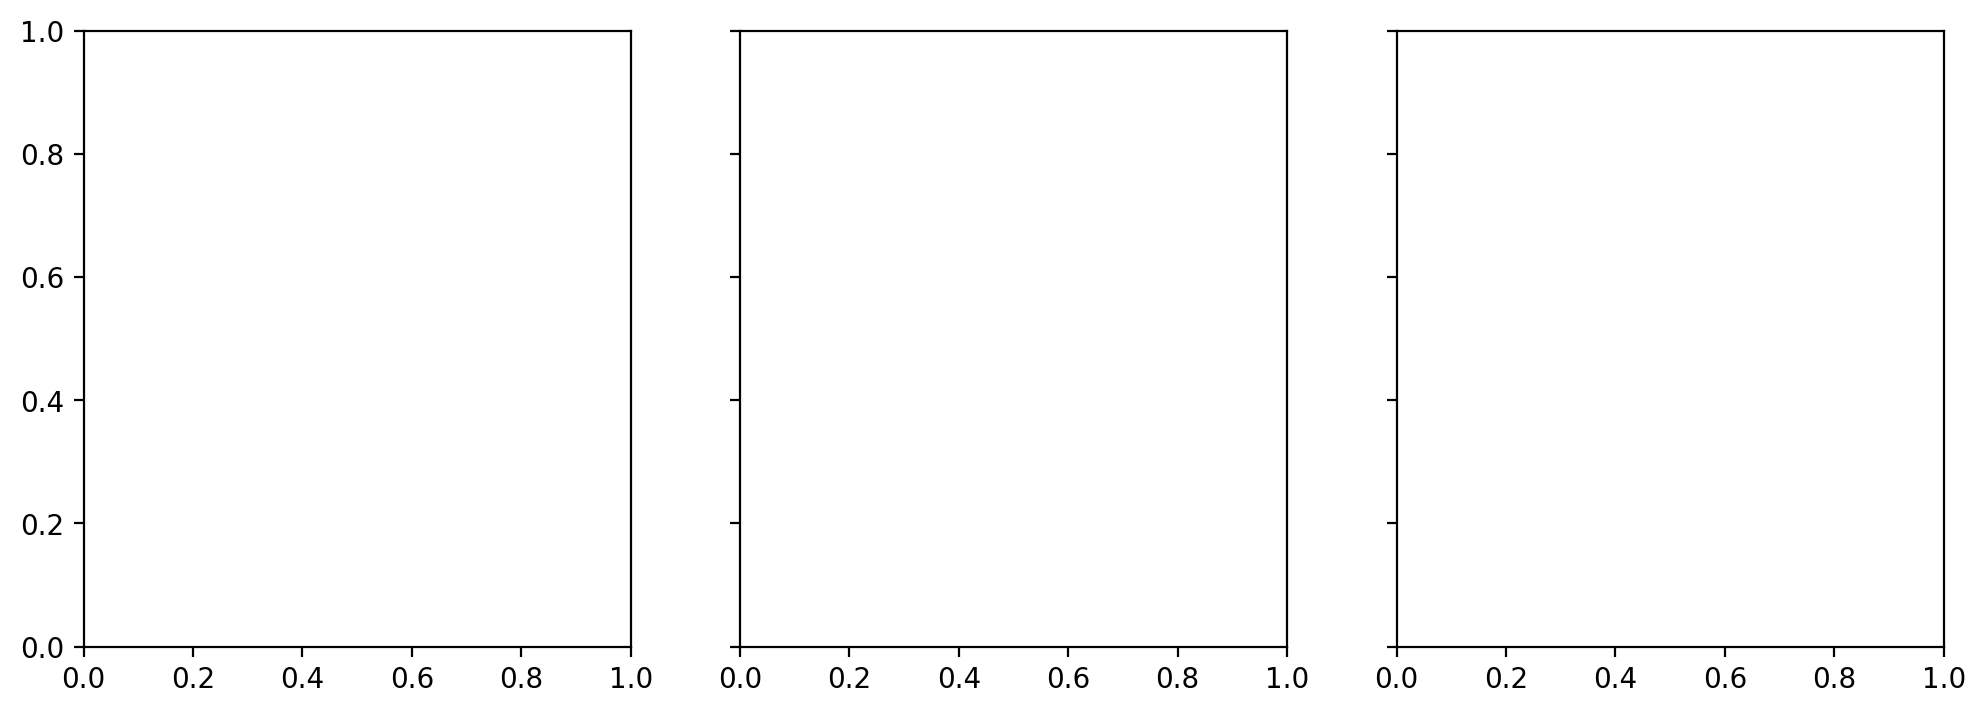

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=200)
# Plot the cumulative distance for leader and follower traces for each strategy
for i in subsample(l1_cd, 2000):
    ax[0].plot(l1_cd[i], color='blue', alpha=0.01)
    ax[0].plot(f1_cd[i], color='orange', alpha=0.01)
ax[0].set_ylabel('Cumulative dist. moved', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[0].set_title('Leader is first to activate', fontsize=12, fontweight='bold')
ax[0].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 1', 'Follower 1'], loc='upper right', fontsize=10, frameon=False
)
for i in subsample(l2_cd, 2000):
    ax[1].plot(l2_cd[i], color='blue', alpha=0.01)
    ax[1].plot(f2_cd[i], color='orange', alpha=0.01)
ax[1].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[1].set_title('Leader first in < 2 a.u. zone', fontsize=12, fontweight='bold')
ax[1].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 2', 'Follower 2'], loc='upper right', fontsize=10, frameon=False
)
for i in subsample(l3_cd, 2000):
    ax[2].plot(l3_cd[i], color='blue', alpha=0.01)
    ax[2].plot(f3_cd[i], color='orange', alpha=0.01)
ax[2].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[2].set_title('Leader is first to rw spot', fontsize=12, fontweight='bold')
ax[2].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 3', 'Follower 3'], loc='upper right', fontsize=10, frameon=False
)
plt.suptitle('Evaluation - raw cumulative distance moved', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1008149/1766729076.py:4: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(ndarray, axis=0)
/home/nuttidalab/miniconda3/envs/relax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


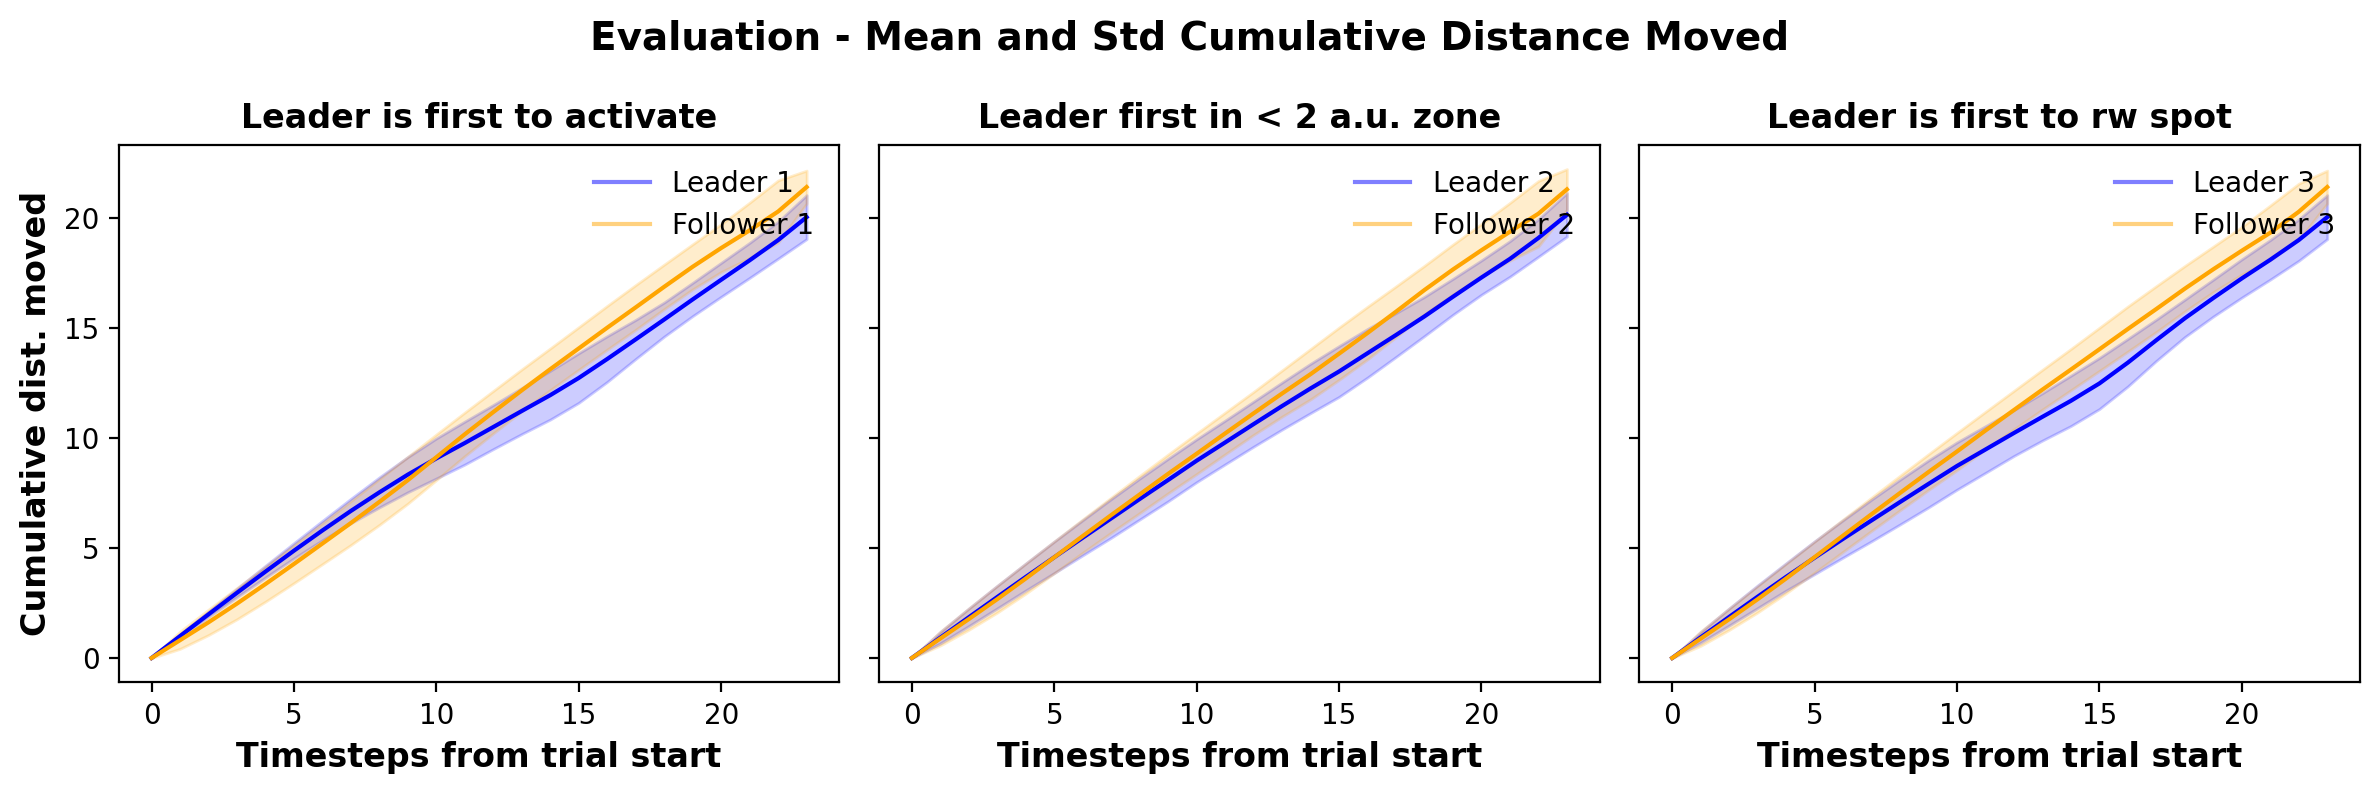

In [55]:
# Same analysis but with mean and std
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=200)
# Plot the mean and std for leader and follower traces for each strategy
mean_l1_cd, std_l1_cd = get_mean_std(l1_cd)
mean_f1_cd, std_f1_cd = get_mean_std(f1_cd)
plot_mean_std(ax[0], mean_l1_cd, std_l1_cd, 'blue', 'Leader 1')
plot_mean_std(ax[0], mean_f1_cd, std_f1_cd, 'orange', 'Follower 1')
mean_l2_cd, std_l2_cd = get_mean_std(l2_cd)
mean_f2_cd, std_f2_cd = get_mean_std(f2_cd)
plot_mean_std(ax[1], mean_l2_cd, std_l2_cd, 'blue', 'Leader 2')
plot_mean_std(ax[1], mean_f2_cd, std_f2_cd, 'orange', 'Follower 2')
mean_l3_cd, std_l3_cd = get_mean_std(l3_cd)
mean_f3_cd, std_f3_cd = get_mean_std(f3_cd)
plot_mean_std(ax[2], mean_l3_cd, std_l3_cd, 'blue', 'Leader 3')
plot_mean_std(ax[2], mean_f3_cd, std_f3_cd, 'orange', 'Follower 3')
ax[0].set_ylabel('Cumulative dist. moved', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[2].set_xlabel('Timesteps from trial start', fontsize=12, fontweight='bold')
ax[0].set_title('Leader is first to activate', fontsize=12, fontweight='bold')
ax[1].set_title('Leader first in < 2 a.u. zone', fontsize=12, fontweight='bold')
ax[2].set_title('Leader is first to rw spot', fontsize=12, fontweight='bold')

ax[0].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 1', 'Follower 1'], loc='upper right', fontsize=10, frameon=False
)
ax[1].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 2', 'Follower 2'], loc='upper right', fontsize=10, frameon=False
)
ax[2].legend(
    [Line2D([0], [0], color='blue', alpha=0.5),
     Line2D([0], [0], color='orange', alpha=0.5)],
    ['Leader 3', 'Follower 3'], loc='upper right', fontsize=10, frameon=False
)
plt.suptitle('Evaluation - Mean and Std Cumulative Distance Moved', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Kde

In [56]:
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from ipywidgets import interact, FloatSlider, IntSlider

In [75]:
l1x, l1y, f1x, f1y = get_lf(tdf.activated_by, tdf)
l2x, l2y, f2x, f2y = get_lf(tdf.first_close_to_zone, tdf)
l3x, l3y, f3x, f3y = get_lf(tdf.first_to_zone, tdf)
l1x.shape, l1y.shape, f1x.shape, f1y.shape, l2x.shape, l2y.shape, f2x.shape, f2y.shape, l3x.shape, l3y.shape, f3x.shape, f3y.shape

((78758, 60),
 (78758, 60),
 (78758, 60),
 (78758, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60))

In [140]:
l1x, l1y, f1x, f1y = get_lf(all_tdf[all_tdf.pair == 51].activated_by, all_tdf[all_tdf.pair == 51])
l2x, l2y, f2x, f2y = get_lf(all_tdf[all_tdf.pair == 51].first_close_to_zone, all_tdf[all_tdf.pair == 51])
l3x, l3y, f3x, f3y = get_lf(all_tdf[all_tdf.pair == 51].first_to_zone, all_tdf[all_tdf.pair == 51])
l1x.shape, l1y.shape, f1x.shape, f1y.shape, l2x.shape, l2y.shape, f2x.shape, f2y.shape, l3x.shape, l3y.shape, f3x.shape, f3y.shape

((78758, 60),
 (78758, 60),
 (78758, 60),
 (78758, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (75171, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60),
 (40606, 60))

In [141]:
def get_density(l1x, l1y, bins=0, sigma=1.0):
    # Drop nans from l1x, l1y for density estimation

    l1x_no_nan = l1x[~np.isnan(l1x)]
    l1y_no_nan = l1y[~np.isnan(l1y)]
    
    subsample_size = np.random.randint(0, l1x_no_nan.shape[0], 10000)
    
    l1x_no_nan = l1x_no_nan[subsample_size]
    l1y_no_nan = l1y_no_nan[subsample_size]

    values = np.vstack([l1x_no_nan, l1y_no_nan])
    kde = gaussian_kde(values)
    # Define a grid over the area of interest
    xi, yi = np.mgrid[0:11:100j, 0:11:100j]
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
    
    return xi, yi, zi.reshape(xi.shape)

def get_density_histogram(l1x, l1y, bins=10, sigma=1.0):
    # Remove nan values
    mask = ~np.isnan(l1x) & ~np.isnan(l1y)
    l1x_no_nan = l1x[mask]
    l1y_no_nan = l1y[mask]
    
    # Compute a 2D histogram (counts per grid cell)
    H, xedges, yedges = np.histogram2d(l1x_no_nan, l1y_no_nan, bins=bins, range=[[0, 11], [0, 11]])
    
    # Smooth the histogram with a Gaussian filter
    H_smooth = gaussian_filter(H, sigma=sigma)
    
    # Create grid for visualization (centers of the bins)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    xi, yi = np.meshgrid(xcenters, ycenters)
    
    return xi, yi, H_smooth


In [142]:
def plot_density(ax, xi, yi, zi, title):
    """Plot the density as a contour plot."""
    ax.contourf(xi, yi, zi, levels=25, cmap="rocket", alpha=1)
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 11)
    ax.set_ylim(0, 11)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, 12, 1))
    ax.set_yticks(np.arange(0, 12, 1))
    
    cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    cbar.set_label('Density', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

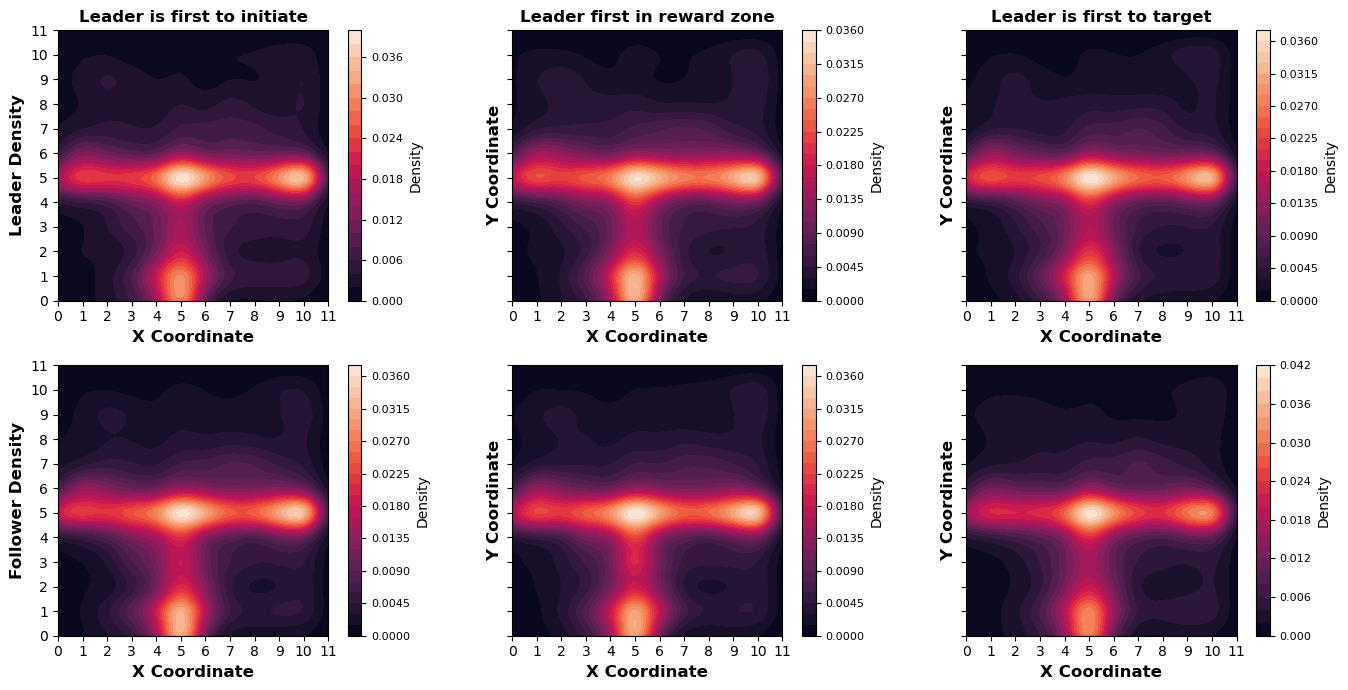

In [143]:
fig, axs = plt.subplots(2, 3, figsize=(14, 7), sharey=True, dpi=100)
ax = axs[0, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density(l1x.flatten(), l1y.flatten())
plot_density(ax[0], xi1, yi1, zi1, 'Leader is first to initiate')
xi2, yi2, zi2 = get_density(l2x.flatten(), l2y.flatten())
plot_density(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
xi3, yi3, zi3 = get_density(l3x.flatten(), l3y.flatten())
plot_density(ax[2], xi3, yi3, zi3, 'Leader is first to target')
# plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

ax = axs[1, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density(f1x.flatten(), f1y.flatten())
plot_density(ax[0], xi1, yi1, zi1, '')
xi2, yi2, zi2 = get_density(f2x.flatten(), f2y.flatten())
plot_density(ax[1], xi2, yi2, zi2, '')
xi3, yi3, zi3 = get_density(f3x.flatten(), f3y.flatten())
plot_density(ax[2], xi3, yi3, zi3, '')
# plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [102]:
def plot_figure(bin_size):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, dpi=100)
    ax = axs[0, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_histogram(l1x.flatten(), l1y.flatten(), bin_size)
    plot_density(ax[0], xi1, yi1, zi1, 'Leader is first initiate')
    xi2, yi2, zi2 = get_density_histogram(l2x.flatten(), l2y.flatten(), bin_size)
    plot_density(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
    xi3, yi3, zi3 = get_density_histogram(l3x.flatten(), l3y.flatten(), bin_size)
    plot_density(ax[2], xi3, yi3, zi3, 'Leader is first to target')
    # plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

    ax = axs[1, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_histogram(f1x.flatten(), f1y.flatten(), bin_size)
    plot_density(ax[0], xi1, yi1, zi1, '')
    xi2, yi2, zi2 = get_density_histogram(f2x.flatten(), f2y.flatten(), bin_size)
    plot_density(ax[1], xi2, yi2, zi2, '')
    xi3, yi3, zi3 = get_density_histogram(f3x.flatten(), f3y.flatten(), bin_size)
    plot_density(ax[2], xi3, yi3, zi3, '')
    # plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

    axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
    axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [18]:
# interact(plot_figure, bin_size=IntSlider(min=2, max=100, step=1, value=20))

## All evals

In [135]:
all_edf = pd.DataFrame()
all_sdf = pd.DataFrame()

last_edf_trial_id = 0
for pairs in tqdm(range(100)):
    # read csv with these columns and datatypes
    store = f"../store_bk/{pairs}/logs/"
    regime = 1
    edf = pd.read_parquet(f'{store}testing_{regime}.parquet')
    # add a pair column to the dataframe
    edf['pair'] = pairs
    edf["trial_id"] = edf.terminated.cumsum().shift(fill_value=0)
    edf["trial_id"] = edf["trial_id"] + last_edf_trial_id + 1
    last_edf_trial_id = edf["trial_id"].max()

    stats = f"../store_bk/{pairs}/trial_stats/"
    sdf = pd.read_parquet(f'{stats}testing_{regime}.parquet')
    sdf['pair'] = pairs
    
    # append to the all_edf and all_sdf dataframes
    all_edf = pd.concat([all_edf, edf], ignore_index=True)
    all_sdf = pd.concat([all_sdf, sdf], ignore_index=True)
# reset the index of the dataframes
all_edf.reset_index(drop=True, inplace=True)
all_sdf.reset_index(drop=True, inplace=True)

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [136]:
all_sdf["trial_id"] = np.arange(all_sdf.shape[0])

In [137]:
all_sdf.shape

(8748810, 15)

### Checking if they hate each spot eqallly

In [ ]:
# df = all_sdf[all_sdf.collected].groupby('pair').collected_zone.value_counts().reset_index(name='count')
# df.sort_values(by=['pair', 'collected_zone'], ascending=[True, True], inplace=True)

In [139]:
# fig, ax = plt.subplots(figsize=(7, 4), dpi=200)
# cols = sns.hls_palette(n_colors=4, h=0.01, l=0.6, s=0.65, as_cmap=False)
# sns.stripplot(data=df, x='collected_zone', y='count', jitter=True, size=5, ax=ax, hue="collected_zone", palette=cols)

# # put a mean dot for each of the collected zones and make a line between them
# mean_counts = df.groupby('collected_zone')['count'].mean()
# for zone, mean_count in mean_counts.items():
#     ax.scatter(zone, mean_count, color='black', s=50, zorder=5)

# # draw a line between the mean points
# plt.plot(mean_counts.index, mean_counts.values, color='black', linestyle='--', linewidth=2, zorder=4)

# plt.xlabel('Collected Zone')
# plt.ylabel('Count')
# plt.title('Each reward target has eqal chance of being disliked', fontsize=14, fontweight='bold')
# plt.show()


### All kdes

In [119]:
all_tdf = all_edf.copy()

# Create new coordinate columns in the trial dataframe
all_sdf["rx"] = all_sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[0])
all_sdf["ry"] = all_sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[1])
# Merge the coordinate columns into the timestep dataframe based on trial_id
all_tdf = all_tdf.merge(all_sdf[['trial_id','trial_length', 'collected', 'collected_zone', "wz_cancel", 'activated_by', 'activated_frame', 'first_close_to_zone', 'first_close_to_zone_frame', 'first_to_zone', 'first_to_zone_frame', 'reward_counter', 'rx', 'ry']], on="trial_id", how="left")
# all_tdf.dropna(inplace=True)

In [128]:
def get_lf_all(strat_coln, tdf):
    pad_size = 60
    g1x = tdf[strat_coln == "a1"].groupby("trial_id")["a1x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby("trial_id")["a1y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby("trial_id")["a2x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby("trial_id")["a2y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    leader_trace_x = np.concatenate((lax, lbx), axis=0)
    leader_trace_y = np.concatenate((lay, lby), axis=0)

    g1x = tdf[strat_coln == "a1"].groupby("trial_id")["a2x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby("trial_id")["a2y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby("trial_id")["a1x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby("trial_id")["a1y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    follower_trace_x = np.concatenate((lax, lbx), axis=0)
    follower_trace_y = np.concatenate((lay, lby), axis=0)
    
    return leader_trace_x, leader_trace_y, follower_trace_x, follower_trace_y

In [ ]:
# l1x, l1y, f1x, f1y = get_lf_all(all_tdf[all_tdf.pair].activated_by, all_tdf[all_tdf.pair])
# l2x, l2y, f2x, f2y = get_lf_all(all_tdf[all_tdf.pair].first_close_to_zone, all_tdf[all_tdf.pair])
# l3x, l3y, f3x, f3y = get_lf_all(all_tdf[all_tdf.pair].first_to_zone, all_tdf[all_tdf.pair])
# l1x.shape, l1y.shape, f1x.shape, f1y.shape, l2x.shape, l2y.shape, f2x.shape, f2y.shape, l3x.shape, l3y.shape, f3x.shape, f3y.shape

In [18]:

def get_density_heatmap(l1x, l1y, bins=11, sigma=1.0):
    # Count the number of frequencies in a 11x11 grid
    H, xedges, yedges = np.histogram2d(l1x, l1y, bins=11, range=[[0, 11], [0, 11]])
    
    # Return unsmooothed histogram
    return xedges, yedges, H

def plot_heatmap(ax, xi, yi, zi, title):
    """Plot the heatmap as a pcolormesh."""
    c = ax.pcolormesh(xi, yi, zi.T, shading='auto', cmap='rocket')
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 11)
    ax.set_ylim(0, 11)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, 12, 1))
    ax.set_yticks(np.arange(0, 12, 1))
    # ax.grid(True, which='both', color='white')
    
    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label('Counts', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

#### individual pairs

In [ ]:
def plot_pair_pos(pair):
    l1x, l1y, f1x, f1y = get_lf_all(all_tdf[all_tdf.pair == pair].activated_by, all_tdf[all_tdf.pair == pair])
    l2x, l2y, f2x, f2y = get_lf_all(all_tdf[all_tdf.pair == pair].first_close_to_zone, all_tdf[all_tdf.pair == pair])
    l3x, l3y, f3x, f3y = get_lf_all(all_tdf[all_tdf.pair == pair].first_to_zone, all_tdf[all_tdf.pair == pair])
    fig, axsed = plt.subplots(4, 3, figsize=(14, 7*2), sharey=True, dpi=100)
    axs = axsed[:2, :]  # Use only the first two rows for density plots
    ax = axs[0, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density(l1x.flatten(), l1y.flatten())
    plot_density(ax[0], xi1, yi1, zi1, 'Leader is first to initiate')
    xi2, yi2, zi2 = get_density(l2x.flatten(), l2y.flatten())
    plot_density(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
    xi3, yi3, zi3 = get_density(l3x.flatten(), l3y.flatten())
    plot_density(ax[2], xi3, yi3, zi3, 'Leader is first to target')
    # plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

    ax = axs[1, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density(f1x.flatten(), f1y.flatten())
    plot_density(ax[0], xi1, yi1, zi1, '')
    xi2, yi2, zi2 = get_density(f2x.flatten(), f2y.flatten())
    plot_density(ax[1], xi2, yi2, zi2, '')
    xi3, yi3, zi3 = get_density(f3x.flatten(), f3y.flatten())
    plot_density(ax[2], xi3, yi3, zi3, '')
    # plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

    axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
    axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

    axs = axsed[2:, :]
    ax = axs[0, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_heatmap(l1x.flatten(), l1y.flatten())
    plot_heatmap(ax[0], xi1, yi1, zi1, 'Leader is first initiate')
    xi2, yi2, zi2 = get_density_heatmap(l2x.flatten(), l2y.flatten())
    plot_heatmap(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
    xi3, yi3, zi3 = get_density_heatmap(l3x.flatten(), l3y.flatten())
    plot_heatmap(ax[2], xi3, yi3, zi3, 'Leader is first to target')
    # plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

    ax = axs[1, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_heatmap(f1x.flatten(), f1y.flatten())
    plot_heatmap(ax[0], xi1, yi1, zi1, '')
    xi2, yi2, zi2 = get_density_heatmap(f2x.flatten(), f2y.flatten())
    plot_heatmap(ax[1], xi2, yi2, zi2, '')
    xi3, yi3, zi3 = get_density_heatmap(f3x.flatten(), f3y.flatten())
    plot_heatmap(ax[2], xi3, yi3, zi3, '')
    # plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

    axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
    axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"cache/{pair}.png", dpi=300)
    plt.close()

In [ ]:
for i in tqdm(range(100)):
    plot_pair_pos(i)

#### All pairs combined